# Rule only

Evaluation in the case of a decision-making system based only on input attributes.
Results obtained with SMACE are compared to those obtained by applying LIME and SHAP on the whole decision system.

In [1]:
import json
import numpy as np
import pandas as pd
import warnings
import shap
import lime.lime_tabular
import sys
from anchor import anchor_tabular


warnings.filterwarnings("ignore")
np.random.seed(seed=1)

In [2]:
sys.path.append('C:/Users/gianl/OneDrive/Desktop/Progs/SMACE/')

In [3]:
from smace.rules import Rule
from smace.decisions import DM
from smace.explainer import Smace
from smace import utils

The input data is a random sample of three uniform variables $x_1$, $x_2$ and $x_3$ in $[0,1]$.

In [4]:
# input data
data = np.random.rand(1000, 3)
df = pd.DataFrame(data, columns=['x1', 'x2', 'x3'])
df.head()

,x1,x2,x3
0,0.417022,0.720324,0.000114
1,0.302333,0.146756,0.092339
2,0.186260,0.345561,0.396767
3,0.538817,0.419195,0.685220
4,0.204452,0.878117,0.027388


In [5]:
# decision rules
with open('rule_simple.json', 'r') as fp:
    rules_json = json.load(fp)

In [6]:
# decision system
dm = DM(rules_json, [], df)  # model_list = []

In [7]:
# Initialize the explainers
explainer = Smace(dm)
data_summary = shap.sample(df, 100)
shap_explainer = shap.KernelExplainer(dm.make_decision_eval, data_summary)
lime_explainer = lime.lime_tabular.LimeTabularExplainer(df.values, feature_names=df.columns,
                                                        discretize_continuous=True, verbose=False,
                                                        mode='classification',
                                                        )

The rule only refers to features. There are no models.

In [8]:
dm.rules['simple'].labels

['x1 <= 0.5', 'x2 >= 0.6', 'x3 >= 0.25']

### Random example
Let us pick a random example in our dataset.

In [9]:
example = np.array(df.loc[1])
print(example)

[0.30233257 0.14675589 0.09233859]


The example does not satisfies all the condition, so it is classified as $0$.

We want to know the contribution of the three variables to that decision.

In [10]:
e = explainer.explain(example, 'simple')
shap_values = shap_explainer.shap_values(example)[0]
exp = lime_explainer.explain_instance(example, dm.make_decision_class)
lime_values = utils.lime_mapper(exp)
res = pd.DataFrame(index=list(e.keys()))
res['SMACE'] = list(e.values())
res['SHAP'] = np.round(shap_values, 3)
res['LIME'] = np.round(lime_values, 3)
res

,SMACE,SHAP,LIME
x1,0.802,0.063,0.177
x2,-0.546,0.063,-0.213
x3,-0.842,0.063,-0.213


<AxesSubplot:>

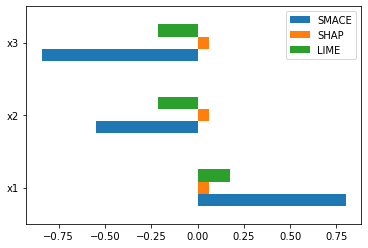

In [11]:
res.plot.barh()

In [12]:
# Anchors
print('Anchors')
anchors_exp = anchor_tabular.AnchorTabularExplainer([0, 1], df.columns, df.values)
exp = anchors_exp.explain_instance(example, dm.make_decision_eval, threshold=0.95)
print('Anchor: %s' % (' AND '.join(exp.names())))
print('Precision: %.2f' % exp.precision())
print('Coverage: %.2f' % exp.coverage())

Anchors
Anchor: x2 <= 0.52
Precision: 1.00
Coverage: 0.50


### Example on the decision boundary
Now we consider an example exactly on the decision boundary, where the sensitivity is maximum.

In [13]:
example = np.array([0.5, 0.6, 0.25])
print(example)

[0.5  0.6  0.25]


The example satisfies all the conditions.

In [14]:
e = explainer.explain(example, 'simple')
shap_values = shap_explainer.shap_values(example)[0]
exp = lime_explainer.explain_instance(example, dm.make_decision_class)
lime_values = utils.lime_mapper(exp)
res = pd.DataFrame(index=list(e.keys()))
res['SMACE'] = list(e.values())
res['SHAP'] = np.round(shap_values, 3)
res['LIME'] = np.round(lime_values, 3)
res

,SMACE,SHAP,LIME
x1,1.0,0.355,-0.201
x2,1.0,0.355,0.121
x3,1.0,0.355,-0.200


<AxesSubplot:>

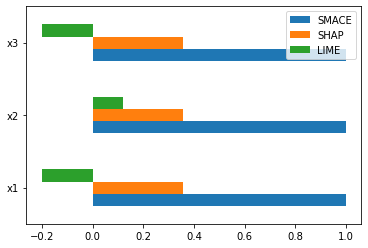

In [15]:
res.plot.barh()

In [16]:
# Anchors
print('Anchors')
anchors_exp = anchor_tabular.AnchorTabularExplainer([0, 1], df.columns, df.values)
exp = anchors_exp.explain_instance(example, dm.make_decision_eval, threshold=0.95)
print('Anchor: %s' % (' AND '.join(exp.names())))
print('Precision: %.2f' % exp.precision())
print('Coverage: %.2f' % exp.coverage())

Anchors
Anchor: x2 > 0.52 AND x1 <= 0.75
Precision: 0.43
Coverage: 0.38


### Slight violation on one attribute
Example with slight violation on $x_1$

In [17]:
example = np.array([0.51, 0.6, 0.25])
print(example)

[0.51 0.6  0.25]


In [18]:
e = explainer.explain(example, 'simple')
shap_values = shap_explainer.shap_values(example)[0]
exp = lime_explainer.explain_instance(example, dm.make_decision_class)
lime_values = utils.lime_mapper(exp)
res = pd.DataFrame(index=list(e.keys()))
res['SMACE'] = list(e.values())
res['SHAP'] = np.round(shap_values, 3)
res['LIME'] = np.round(lime_values, 3)
res

,SMACE,SHAP,LIME
x1,-0.99,-0.29,-0.211
x2,1.00,-0.29,0.126
x3,1.00,-0.29,-0.220


<AxesSubplot:>

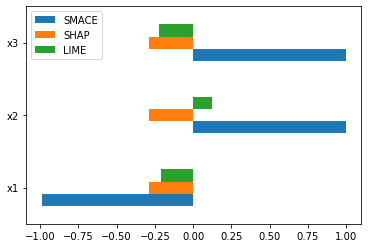

In [19]:
res.plot.barh()

In [20]:
# Anchors
print('Anchors')
anchors_exp = anchor_tabular.AnchorTabularExplainer([0, 1], df.columns, df.values)
exp = anchors_exp.explain_instance(example, dm.make_decision_eval, threshold=0.95)
print('Anchor: %s' % (' AND '.join(exp.names())))
print('Precision: %.2f' % exp.precision())
print('Coverage: %.2f' % exp.coverage())

Anchors
Anchor: x3 <= 0.25
Precision: 1.00
Coverage: 0.25


### Violation on two attributes
Let us now analyze the case where the rules on two variables are violated. 
This means that in order to bring the result into $1$ it is necessary to move two variables simultaneously.

In [21]:
example = np.array([0.6, 0.1, 0.8])
print(example)

[0.6 0.1 0.8]


In [22]:
e = explainer.explain(example, 'simple')
shap_values = shap_explainer.shap_values(example)[0]
exp = lime_explainer.explain_instance(example, dm.make_decision_class)
lime_values = utils.lime_mapper(exp)
res = pd.DataFrame(index=list(e.keys()))
res['SMACE'] = list(e.values())
res['SHAP'] = np.round(shap_values, 3)
res['LIME'] = np.round(lime_values, 3)
res

,SMACE,SHAP,LIME
x1,-0.900,-0.078,-0.199
x2,-0.499,-0.078,-0.204
x3,0.450,-0.078,0.069


<AxesSubplot:>

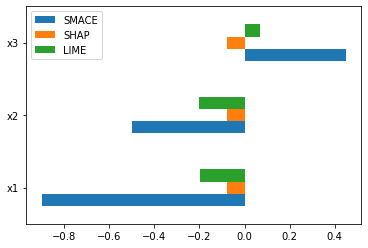

In [23]:
res.plot.barh()

In [24]:
# Anchors
print('Anchors')
anchors_exp = anchor_tabular.AnchorTabularExplainer([0, 1], df.columns, df.values)
exp = anchors_exp.explain_instance(example, dm.make_decision_eval, threshold=0.95)
print('Anchor: %s' % (' AND '.join(exp.names())))
print('Precision: %.2f' % exp.precision())
print('Coverage: %.2f' % exp.coverage())

Anchors
Anchor: x2 <= 0.52
Precision: 1.00
Coverage: 0.50


### Violation on each attribute

In [25]:
example = np.array([0.65, 0.59, 0.14])
print(example)

[0.65 0.59 0.14]


In [26]:
e = explainer.explain(example, 'simple')
shap_values = shap_explainer.shap_values(example)[0]
exp = lime_explainer.explain_instance(example, dm.make_decision_class)
lime_values = utils.lime_mapper(exp)
res = pd.DataFrame(index=list(e.keys()))
res['SMACE'] = list(e.values())
res['SHAP'] = np.round(shap_values, 3)
res['LIME'] = np.round(lime_values, 3)
res

,SMACE,SHAP,LIME
x1,-0.85,-0.047,-0.209
x2,-0.99,-0.047,0.142
x3,-0.89,-0.047,-0.214


<AxesSubplot:>

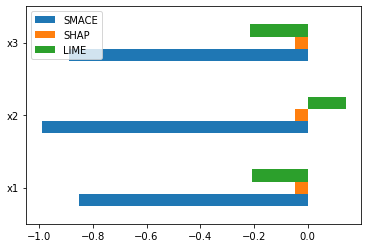

In [27]:
res.plot.barh()

In [28]:
# Anchors
print('Anchors')
anchors_exp = anchor_tabular.AnchorTabularExplainer([0, 1], df.columns, df.values)
exp = anchors_exp.explain_instance(example, dm.make_decision_eval, threshold=0.95)
print('Anchor: %s' % (' AND '.join(exp.names())))
print('Precision: %.2f' % exp.precision())
print('Coverage: %.2f' % exp.coverage())

Anchors
Anchor: x3 <= 0.25
Precision: 1.00
Coverage: 0.25


In [31]:
exp.examples()

array([[0.5152147 , 0.4788234 , 0.22449348],
       [0.00704672, 0.05952861, 0.04431166],
       [0.62417972, 0.26483666, 0.02291513],
       [0.31898601, 0.12191981, 0.19964557],
       [0.52178121, 0.78847913, 0.23698206],
       [0.21369324, 0.76728451, 0.19446581],
       [0.00531653, 0.2772001 , 0.0511109 ],
       [0.53128781, 0.24829073, 0.18756989],
       [0.96303234, 0.93826177, 0.18819426],
       [0.53376109, 0.10315472, 0.02452249]])